# A/B-тесты

## Задача 2. A/B-тест.

Есть результаты A/B-теста, проведенного с командой дата-сайентистов с 2023-09-28 по 2023-10-04. Использовались 2 и 1 группы, причем во 2-й группе был применен новый алгоритм рекомендации постов, а 1-я была контрольной.

Основная гипотеза: новый алгоритм во 2-й группе увеличит CTR. Необходимо проанализировать данные A/B-теста, выбрав метод анализа и сравнив CTR в обеих группах (используя различные тесты, такие как t-тест, Пуассоновский бутстрэп, тест Манна-Уитни и другие). Также нужно визуально оценить распределения данных и объяснить, почему те или иные тесты показали определенные результаты. И, наконец, дать рекомендацию: стоит ли внедрять новый алгоритм для всех новых пользователей или лучше воздержаться.

In [48]:
import pandas as pd
import pandahouse as ph
import numpy as np
import seaborn as sns
import matplotlib as mpl
from scipy import stats

In [49]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20231020',
'user':'student',
'password':'dpo_python_2020'
}

In [50]:
query = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-09-28' and '2023-10-04'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

In [51]:
df = ph.read_clickhouse(query, connection=connection)

In [52]:
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,18392,7,32,0.218750
4,1,26295,39,141,0.276596


Убедимся, равное ли количество пользователей в каждой из групп, а также сравним средние показатели ctr.

In [53]:
df[df['exp_group']==1].ctr.describe(), df[df['exp_group']==2].ctr.describe()

(count    10020.000000
 mean         0.216774
 std          0.082969
 min          0.000000
 25%          0.163636
 50%          0.205882
 75%          0.257870
 max          0.722222
 Name: ctr, dtype: float64,
 count    9877.000000
 mean        0.216102
 std         0.142870
 min         0.000000
 25%         0.096774
 50%         0.153285
 75%         0.323529
 max         0.900000
 Name: ctr, dtype: float64)

Количество в пользователей в группах примерно одинаковое. При этом, средние значения также похожи, но вот стандартное отклонение довольно сильно различается, что может говорить о том, что выборки распределены по разному. Отобразим результаты на графике, используя гистограмму значений ctr каждой из групп:

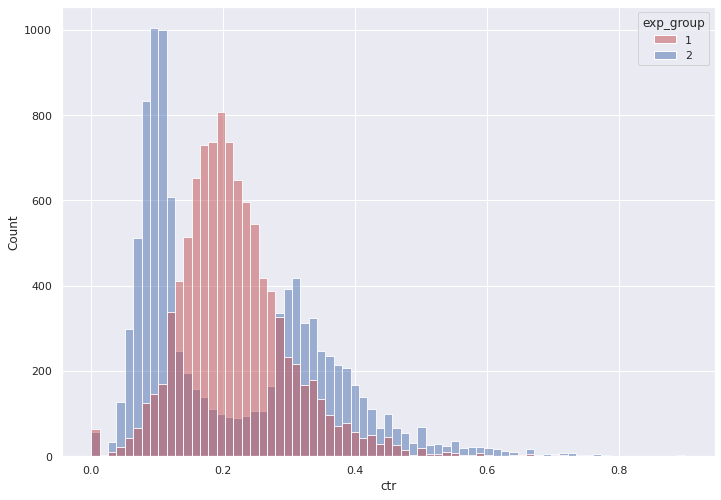

In [54]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df,
                     x = 'ctr',
                     hue = 'exp_group',
                     palette = ['r','b'],
                     alpha = 0.5)

На гистограмме можно наблюдать различия: у первой группы распределение похоже на нормальное, унимодальное, когда у второй группы оно не похоже на нормальное, присутствует бимодальность. У первой группы разброс не такой большой, как у второй.

Следует также отметить, что для первой группы у большего количества пользователей стало характерно с одной стороны уменьшилось соотношение лайков к просмотров (приблизительно с 0.2 до 0.1), но с другой стороны увеличилось и количество пользователей, которые лайкали посты чаще.

Тем не менее, средние значения метрики ctr очень схожи, из-за чего нельзя сказать, что новая система рекомендаций как-либо повлияла на нее.

t-test Стьюдента сравнивает средние, а в нашем случае он будет не так полезен, поскольку значения средних примерно одинаковые. Докажем это:

$$
\text{Нулевая гипотеза } H_0 : \mu_1 = \mu_2 
$$

$$
\text{Альтернативная гипотеза } H_1 : \mu_1 \neq \mu_2
$$

In [55]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

P value сильно большой, из-за чего напрашивается вывод, что различия между выборками не являются статистически значимым. Однако, результаты неожиданны, поскольку на экспериментальную группы выкатили систему рекомендаций, что должно было как-то сказаться на результатах. Есть вероятность допустить ошибку второго рода. Копаем дальше.

Проведем U test Манна-Уитни:

$$
\text{Нулевая гипотеза } H_0: P(X>Y) = P(Y>X)
$$

$$
\text{Альтернативная гипотеза } H_1: P(X>Y) \neq P(Y>X)
$$

In [56]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr)

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

Тест Манна-Уитни прокрасился, что означает, что выборки различаются

Можно предположить, что некоторые пользователи просто еще не начали получать рекомендации по причине того, что они еще не успели поставить лайки (то есть постов просмотренно не так много, а это все равно скажется на статистике). Из-за того, что пользователи имеют разное количество просмотров, метрика ctr зашумлена (большая дисперсия). Для этого нам может понадобиться сглаженный ctr. 

Проведем сглаживание Лапласа: 
$$
\text{Smoothed CTR}_u = \frac{\text{clicks}_u + \alpha \cdot \text{globalCTR}}{\text{views}_u + \alpha}
$$

In [57]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

df['smothed_ctr1'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
df['smothed_ctr2'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

In [72]:
group1 = df[df.exp_group == 1].copy()
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)


group2 = df[df.exp_group == 2].copy()

group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

Сравним t-тестом Стьюдента на сглаженном ctr

In [60]:
stats.ttest_ind(df[df['exp_group']==1].smothed_ctr1, 
                df[df['exp_group']==2].smothed_ctr2, 
                equal_var=False)

Ttest_indResult(statistic=1.9460491517027683, pvalue=0.05166679015318526)

Хотя p value t-теста стало гораздо ближе к 0.05, оно все еще выше, из-за чего нулевую гипотезу отвергнуть мы не можем. К тому же, на сглаженном ctr нет теоретических гарантий, из-за чего уверенно утверждать о результате пока рано, поэтому исследуем дальше.

## **Пуассоновский бутстреп для подсчета разницы в CTR**

In [62]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

<Axes: ylabel='Count'>

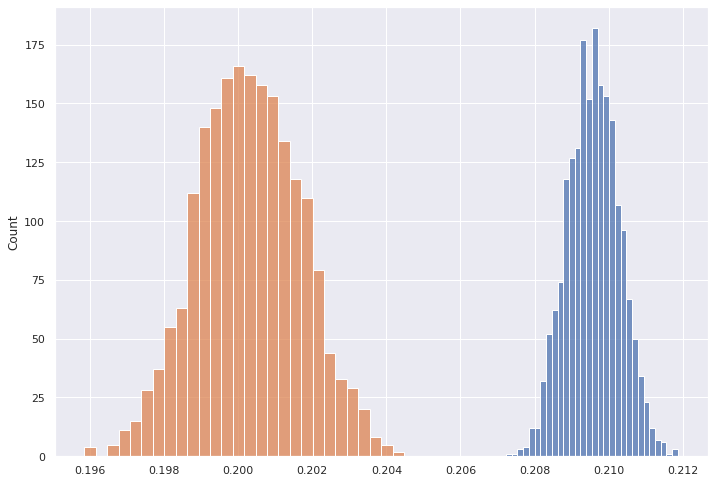

In [63]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

Из построенной гистограммы можно заметить, что новый алгоритм группы два (оранжевый на графике) заметно хуже, чем старый (синий на графике).

<Axes: ylabel='Count'>

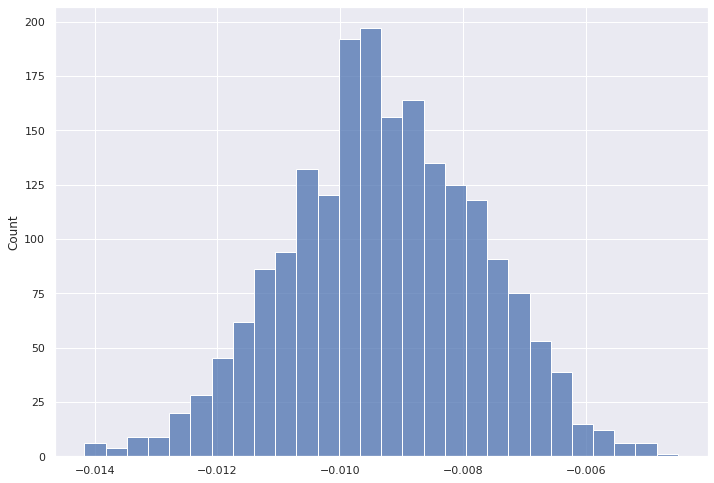

In [64]:
sns.histplot(ctr2 - ctr1)

Разница глобальных ctr говорит нам о том, что показатель ctr контрольной группы (1) был выше.

## **Бакетное преобразование**

In [65]:
q1 = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-09-28' and '2023-10-04'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df1 = ph.read_clickhouse(q1, connection=connection)

Применим тест Манна-Уитни поверх бакетного преобразования:

In [66]:
stats.mannwhitneyu(df1[df1.exp_group == 1].bucket_ctr, 
                   df1[df1.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

Также применим t-тест:

In [67]:
stats.ttest_ind(df1[df1.exp_group == 1].bucket_ctr, 
                   df1[df1.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)

Оба теста показали p value < 0.05, значит что отличия действительно значимые.

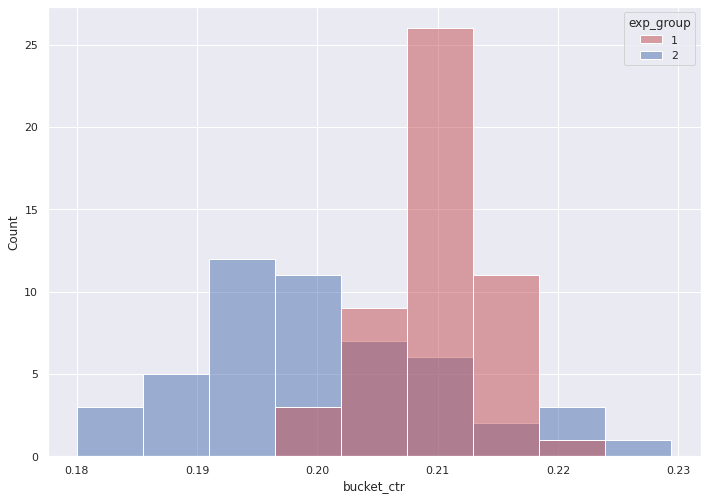

In [78]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
groups0 = sns.histplot(data = df1,
                     x = 'bucket_ctr',
                     hue = 'exp_group',
                     palette = ['r', 'b'],
                     alpha = 0.5,
                     kde = False)

Можно заметить, что и бакетное распределение явно различается, где результат контрольной группы гораздо правее, а значит ctr ее больше чем у экспериментальной.

## **Вывод**

С точки зрения общегруппового ctr новый алгоритм показал значения хуже, чем были до его введения. Сначала мы заметили это на построенной гистограмме, а затем доказали это, в частности, бутстрепом, а также тестом Манна-Уитни. **На всех пользователей данный алгоритм раскатывать не стоит, поскольку он ухудшает целевую метрику.**

Тем не менее, алгоритм действительно внес некие изменения, где у части пользователей ctr просел, а у другой он повысился (наблюдается бимодальность).